In [2]:
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from post_repp_utils import combine_tasks_to_csv


### Save result as CSV

In [3]:
# base_pkl_dir = r"output\italy-group1-final"
# sub_dirs = ["Task 1", "Task 2"]

# combine_tasks_to_csv(base_pkl_dir, sub_dirs, "all_tasks_combined.csv")

### Load csv

In [4]:
group = "Italy Group 1 AWS"
# exp_dir = r"output\Mali Group 1 AWS"
# exp_dir = r"output\Mali Group 1"
# exp_dir = r"output\US Group 1"

exp_dir = r"output\italy-group1-aws"

csv_file = os.path.join(exp_dir, "all_tasks_combined.csv")        # TapTrialMusic.csv


final_df = pd.read_csv(csv_file)


# Function to get IOIs from a row
def get_ioi_from_stim_onsets(row):
    stim_onsets = row.get('output.resp_onsets_detected', [])
    # If it's a string, parse it
    if isinstance(stim_onsets, str):
        try:
            stim_onsets = json.loads(stim_onsets)
        except Exception:
            return np.array([])
    stim_onsets = np.array(stim_onsets)
    if stim_onsets.size < 2:
        return np.array([])

    return np.diff(stim_onsets)

# Add a new column with IOIs for each trial
final_df['stim_ioi'] = final_df.apply(get_ioi_from_stim_onsets, axis=1)

df_passed_trials = final_df[final_df['stats.failed'] == False].copy()
df_failed_trials = final_df[final_df['stats.failed'] == True].copy()

# Example: aggregate median IOI per participant and stimulus
median_ioi_per_participant_stim = (
    df_passed_trials.explode('stim_ioi')
    .dropna(subset=['stim_ioi'])
    .groupby(['participant_id', 'stim_name'])['stim_ioi']
    .median()
    .unstack()
    )

print(final_df.shape[0])
print("Number of passed trials:", len(df_passed_trials))
print("Number of failed trials:", len(df_failed_trials))


360
Number of passed trials: 360
Number of failed trials: 0


### Plot: Median IOI per Stimulus and Participant

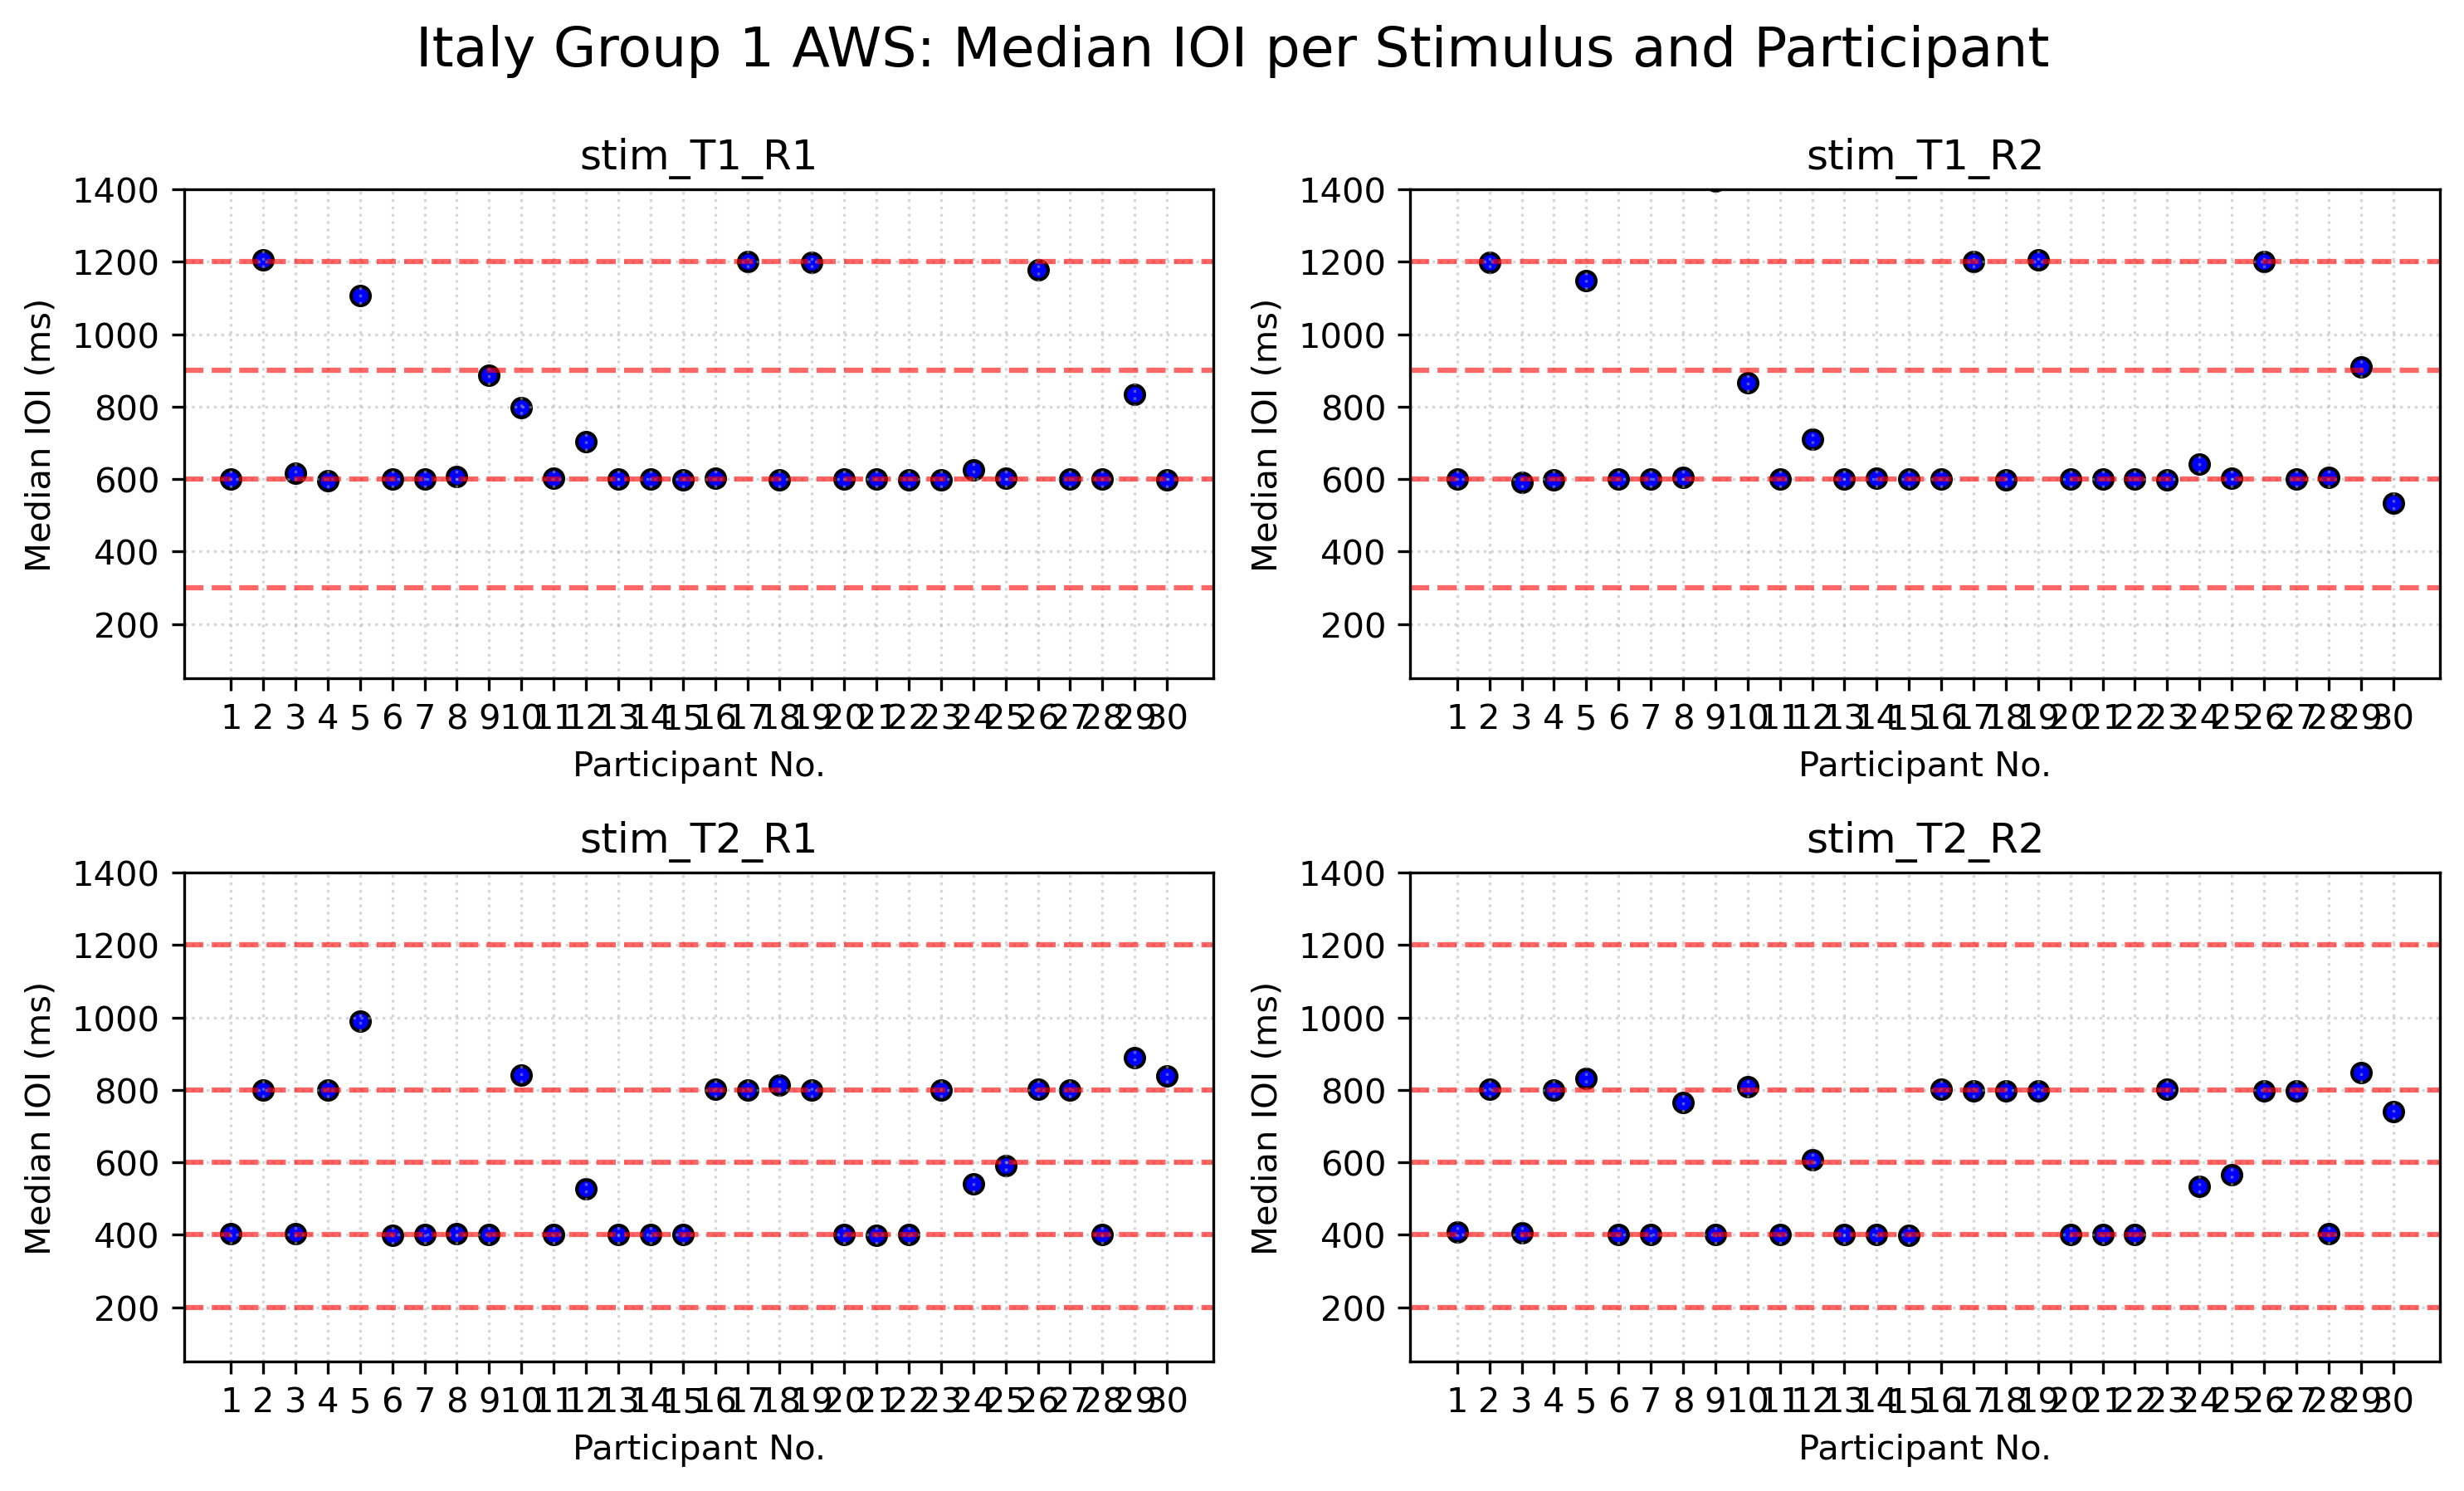

In [5]:

# 2. Prepare plotting parameters
stimuli = median_ioi_per_participant_stim.columns.tolist()

hypotheses = {
    "T1": [300, 600, 900, 1200, 1800],
    "T2": [200, 400, 600, 800, 1200]
}
y_limits = {
    "T1": (50, 1400),
    "T2": (50, 1400)
}
%matplotlib inline
# 3. Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=300, sharey=False)
axes = axes.flatten()

# if len(stimuli) == 1:
#     axes = [axes]  # Ensure axes is iterable

for idx, stim in enumerate(stimuli):
    ax = axes[idx]
    iois = median_ioi_per_participant_stim[stim].values
    participants = median_ioi_per_participant_stim.index.values
    participant_ids = np.arange(1, len(participants)+1)

    # Scatter plot
    ax.scatter(participant_ids, iois, color="blue", edgecolors="black", s=30)

    # Plot hypothesis lines
    condition = "T1" if "T1" in stim else "T2"
    for line in hypotheses[condition]:
        ax.axhline(y=line, color="red", linestyle="dashed", alpha=0.6)

    ax.set_title(f"{stim}")
    ax.set_xlabel("Participant No.")
    ax.set_ylabel("Median IOI (ms)")
    ax.set_ylim(y_limits[condition])
    ax.set_xticks(np.arange(1, len(participants)+1, 1))  # Show ticks from 1 to 20 with step 1
    ax.grid(True, linestyle="dotted", alpha=0.5)

plt.suptitle(f"{group}: Median IOI per Stimulus and Participant", fontsize=16, y=0.99)
plt.tight_layout()

save_path = os.path.join(exp_dir, f"{group}_Median_IOI_per_Stimulus_and_Participant.png")
plt.savefig(save_path, dpi=300)

plt.show()

## Per Trial

In [6]:
# Function to get median IOI from a row (for each trial)
def get_median_ioi_from_trial(row):
    stim_onsets = row.get('output.resp_onsets_detected', [])
    # If it's a string, parse it
    if isinstance(stim_onsets, str):
        try:
            stim_onsets = json.loads(stim_onsets)
        except Exception:
            return np.nan
    stim_onsets = np.array(stim_onsets)
    if stim_onsets.size < 2:
        return np.nan
    
    # Calculate IOIs for this trial
    iois = np.diff(stim_onsets)
    # Return median IOI for this trial
    return np.median(iois)

# Filter final_df to only include Task 1 and Task 2
filtered_df =df_passed_trials[df_passed_trials['trial_maker_id'].isin(['Task 1', 'Task 2'])].copy()

# Add a new column with median IOI for each trial
filtered_df['trial_median_ioi'] = filtered_df.apply(get_median_ioi_from_trial, axis=1)

Total rows in filtered_df: 360
Total trial_median_ioi values: 360
Non-null trial_median_ioi values: 360
Null trial_median_ioi values: 0
  Number of participants: 30
  Total IOIs plotted for stim_T1_R1: 90
  Number of participants: 30
  Total IOIs plotted for stim_T1_R2: 90
  Number of participants: 30
  Total IOIs plotted for stim_T2_R1: 90
  Number of participants: 30
  Total IOIs plotted for stim_T2_R2: 90

Total IOIs plotted across all stimuli: 360


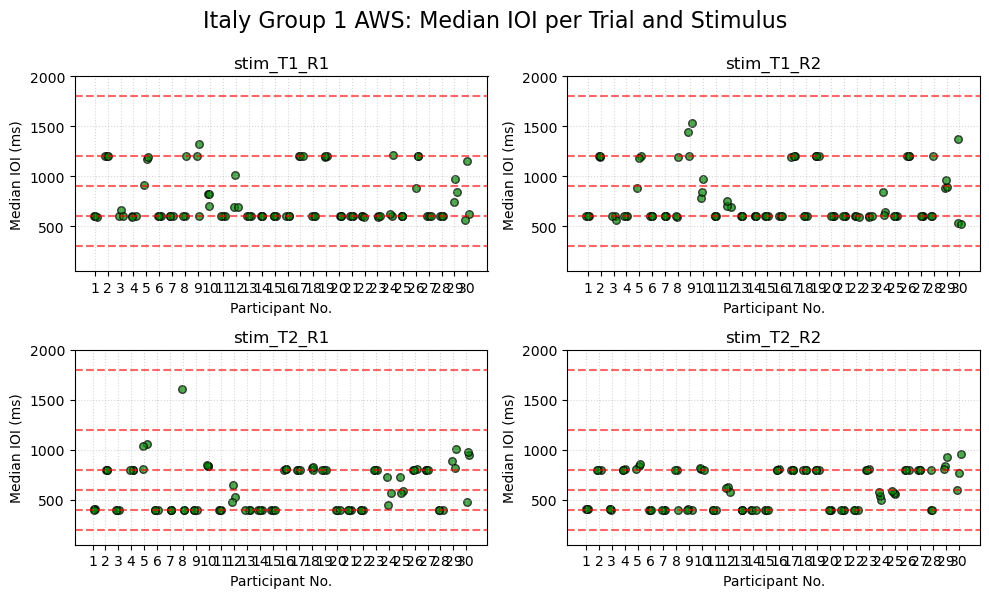

In [7]:

# Define plotting parameters
stimuli = ['stim_T1_R1', 'stim_T1_R2', 'stim_T2_R1', 'stim_T2_R2']

hypotheses = {
    "T1": [300, 600, 900, 1200, 1800],
    "T2": [200, 400, 600, 800, 1200, 1800]
}
y_limits = {
    "T1": (50, 2000),
    "T2": (50, 2000)
}

# Debug: Check total data
print(f"Total rows in filtered_df: {len(filtered_df)}")
print(f"Total trial_median_ioi values: {len(filtered_df['trial_median_ioi'])}")
print(f"Non-null trial_median_ioi values: {filtered_df['trial_median_ioi'].notna().sum()}")
print(f"Null trial_median_ioi values: {filtered_df['trial_median_ioi'].isna().sum()}")

# Create 4 subplots (one per stimulus)
fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=100, sharey=False)
axes = axes.flatten()
total_plotted = 0

for idx, stim in enumerate(stimuli):
    ax = axes[idx]
    
    # Filter data for this stimulus
    stim_data = filtered_df[filtered_df['stim_name'] == stim]
    
    # Debug: Check data for this stimulus
    # print(f"\n{stim}:")
    # print(f"  Rows for this stimulus: {len(stim_data)}")
    # print(f"  Non-null IOIs for this stimulus: {stim_data['trial_median_ioi'].notna().sum()}")
    
    
    # Get unique participants and sort them
    participants = sorted(stim_data['participant_id'].unique())
    print(f"  Number of participants: {len(participants)}")
    
    # For each participant, get their trial median IOIs
    all_iois = []
    participant_positions = []
    
    for i, participant_id in enumerate(participants):
        participant_trials = stim_data[stim_data['participant_id'] == participant_id]
        trial_iois = participant_trials['trial_median_ioi'].values
        # print(participant_id)
        
        # Add trial IOIs for this participant
        for j, ioi in enumerate(trial_iois):
            if not np.isnan(ioi):
                all_iois.append(ioi)
                
                jitter = random.uniform(-0.2, 0.2)
                participant_positions.append(i + 1 + jitter)  # Participant number
            # print(ioi)
    
    print(f"  Total IOIs plotted for {stim}: {len(all_iois)}")
    total_plotted += len(all_iois)
    
    # Scatter plot
    ax.scatter(participant_positions, all_iois, color="green", edgecolors="black", s=30, alpha=0.7)

    
    # Plot horizontal hypothesis lines
    condition = "T1" if "T1" in stim else "T2"
    for line in hypotheses[condition]:
        ax.axhline(y=line, color="red", linestyle="dashed", alpha=0.6)
    
    # Set labels and title
    ax.set_title(f"{stim}")
    ax.set_xlabel("Participant No.")
    ax.set_ylabel("Median IOI (ms)")
    ax.set_ylim(y_limits[condition])
    ax.set_xticks(np.arange(1, len(participants)+1, 1))  # Show ticks from 1 to 20 with step 1
    ax.grid(True, linestyle="dotted", alpha=0.5)

print(f"\nTotal IOIs plotted across all stimuli: {total_plotted}")

# Adjust layout
plt.suptitle(f"{group}: Median IOI per Trial and Stimulus", fontsize=16, y=0.99)
plt.tight_layout()

save_path = os.path.join(exp_dir, f"{group}_Median IOI per Trial and Stimulus.png")
plt.savefig(save_path, dpi=300)

plt.show()